# 1- Importation et préparation des données

In [124]:
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime
import statistics as st
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
import os



data_temperature = pd.read_table('../data/observatoire-geneve/TG_STAID000241.txt',sep = ',',
                                names = ['SOUID','DATE','TG','Q_TG'], skiprows = range(0,20))

data_temperature.drop(data_temperature[ data_temperature['Q_TG'] == 9 ].index, inplace = True)
data_temperature['Year'] = [int(str(d)[:4]) for d in data_temperature.DATE]
data_temperature['Month'] = [int(str(d)[4:6]) for d in data_temperature.DATE]
data_temperature['Day'] = [int(str(d)[6:8]) for d in data_temperature.DATE]

#Compute the day of the year for each year
day_of_year = np.array(len(data_temperature['Day']))

adate = [datetime.strptime(str(date),"%Y%m%d") for date in data_temperature.DATE]
data_temperature['Day_of_year'] = [d.timetuple().tm_yday for d in adate]
data_temperature.TG = data_temperature.TG/10.


In [104]:
df = data_temperature

# 2- Analyse exploratoire des données comme des Time Series

## 2.1- Seasonal Plot of temperature

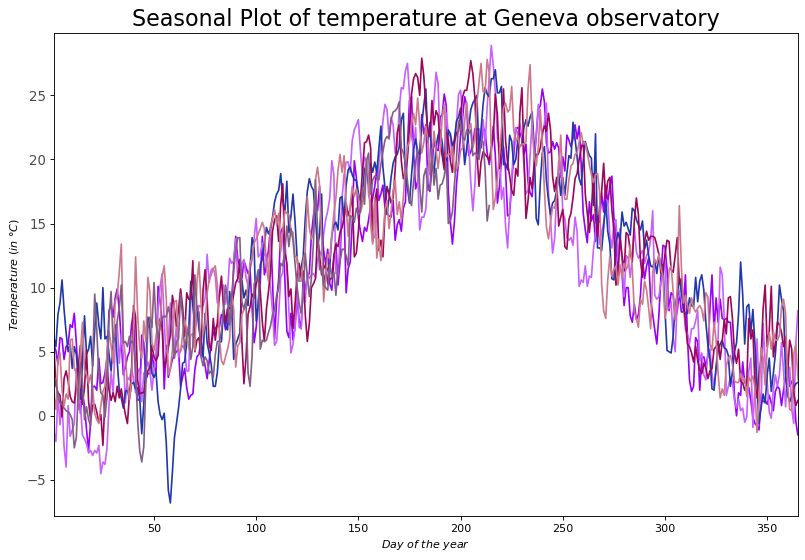

In [25]:
df1 = df[df.Year>2015]
years = df1['Year'].unique()
# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(12,8), dpi= 80)

for i, y in enumerate(years):        
    plt.plot('Day_of_year','TG',data=df1[df1.Year==y], color=mycolors[i], label=y)
        

# Decoration
plt.gca().set(xlim=(1, 365), ylim=(min(df1.TG) - 1, max(df1.TG) + 1),
              ylabel='$Temperature\ (in\ °C)$', xlabel='$Day\ of\ the\ year$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of temperature at Geneva observatory", fontsize=20)
plt.show()

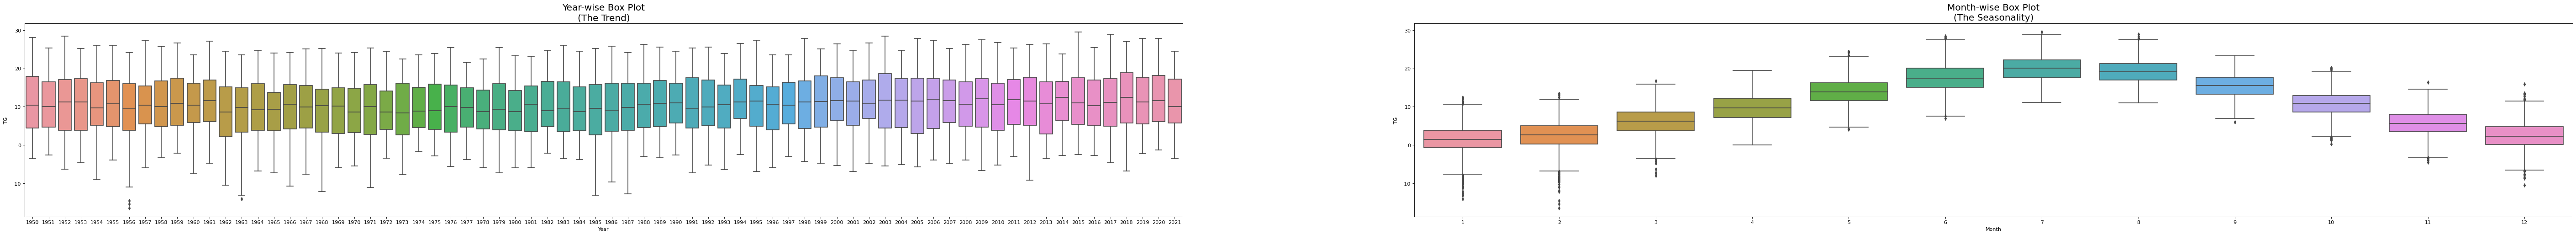

In [26]:
df1 = df[df.Year >= 1950]
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(90,7), dpi= 80)
sns.boxplot(x='Year', y='TG', data=df1, ax=axes[0])
sns.boxplot(x='Month', y='TG', data=df1)

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

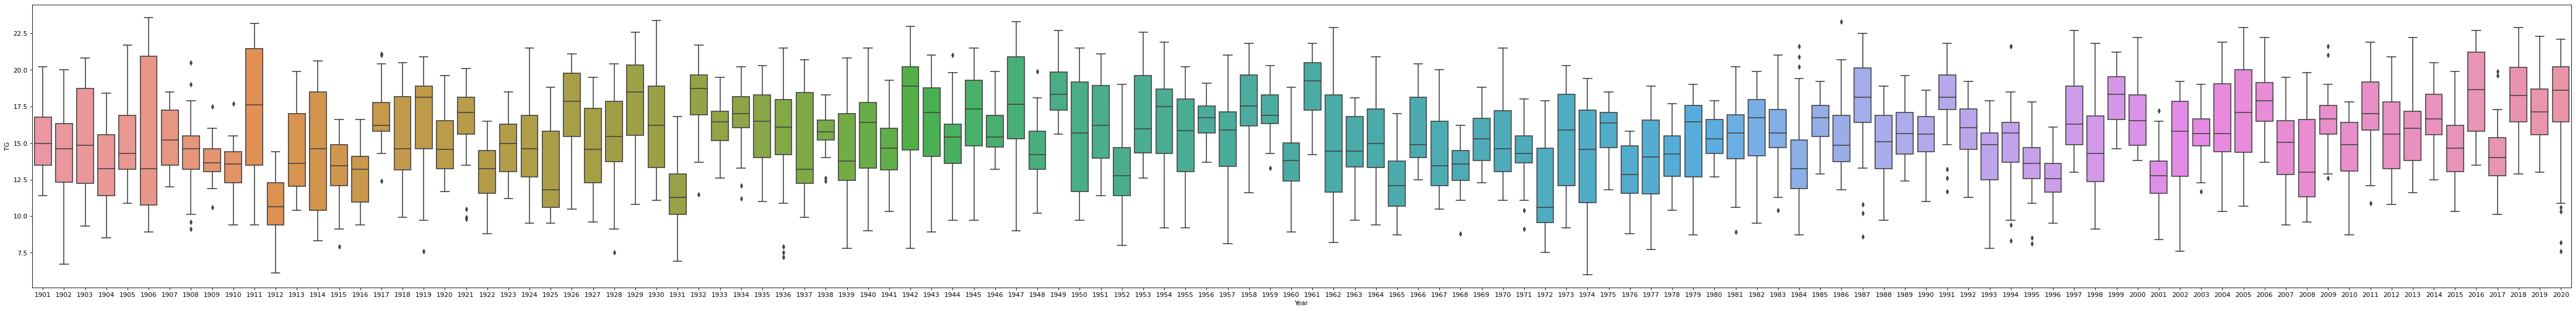

In [27]:
# Draw Plot
plt.figure(figsize=(70,8), dpi= 80)
sns.boxplot(x='Year', y='TG', data=df[df.Month == 9] )

#plt.plot(years,[st.mean(df.TG[df.Year == year]) for year in years])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

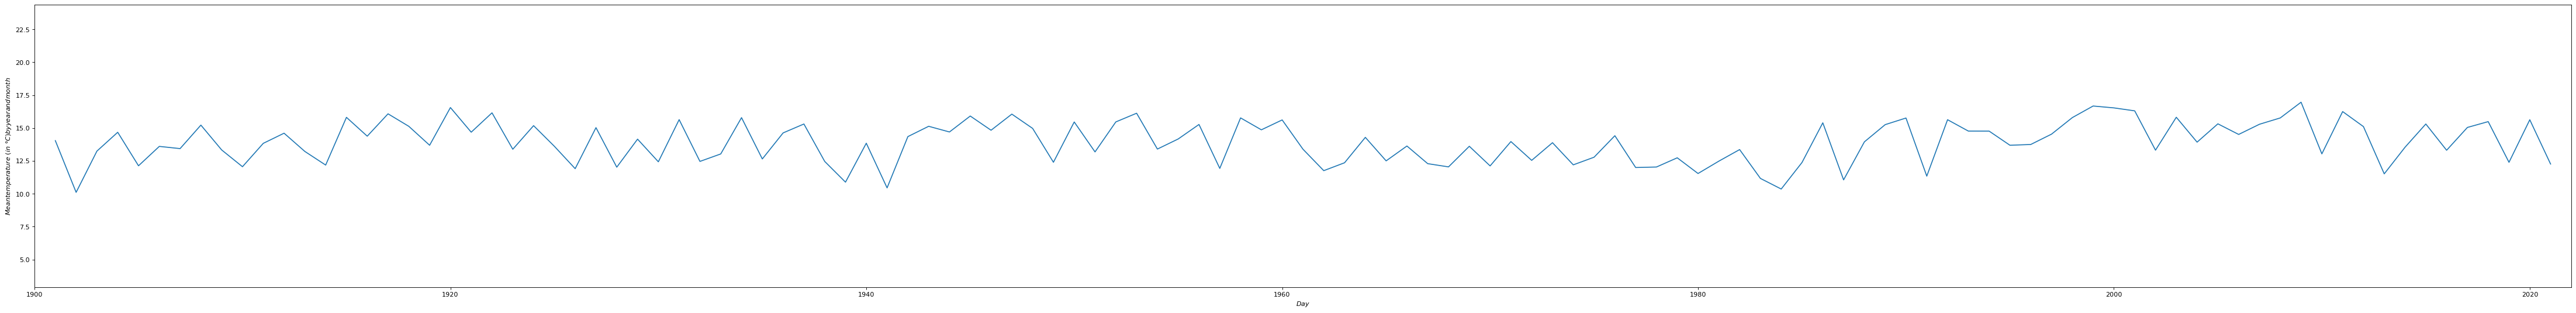

In [28]:
years = df['Year'].unique()
# Draw Plot
plt.figure(figsize=(70,8), dpi= 80)
month = 5
plt.plot(years,[st.mean(df.TG[(df.Year == year) & (df.Month == month)]) for year in years])

# Set Title
plt.gca().set(xlim=(1900, 2022), ylim=(min(df.TG[df.Month == month]), max(df.TG[df.Month == month])),
              ylabel='$Mean temperature\ (in\ °C) by year and month$', xlabel='$Day$')
plt.show()

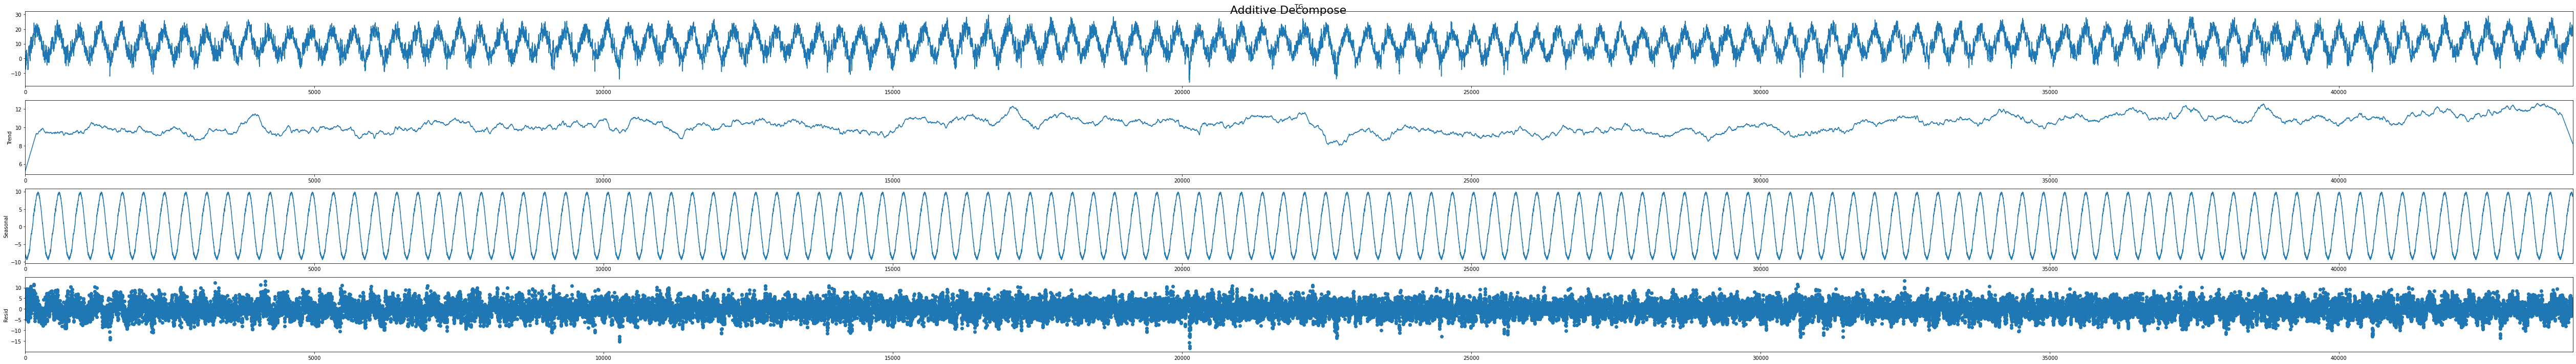

0.012336177948328156


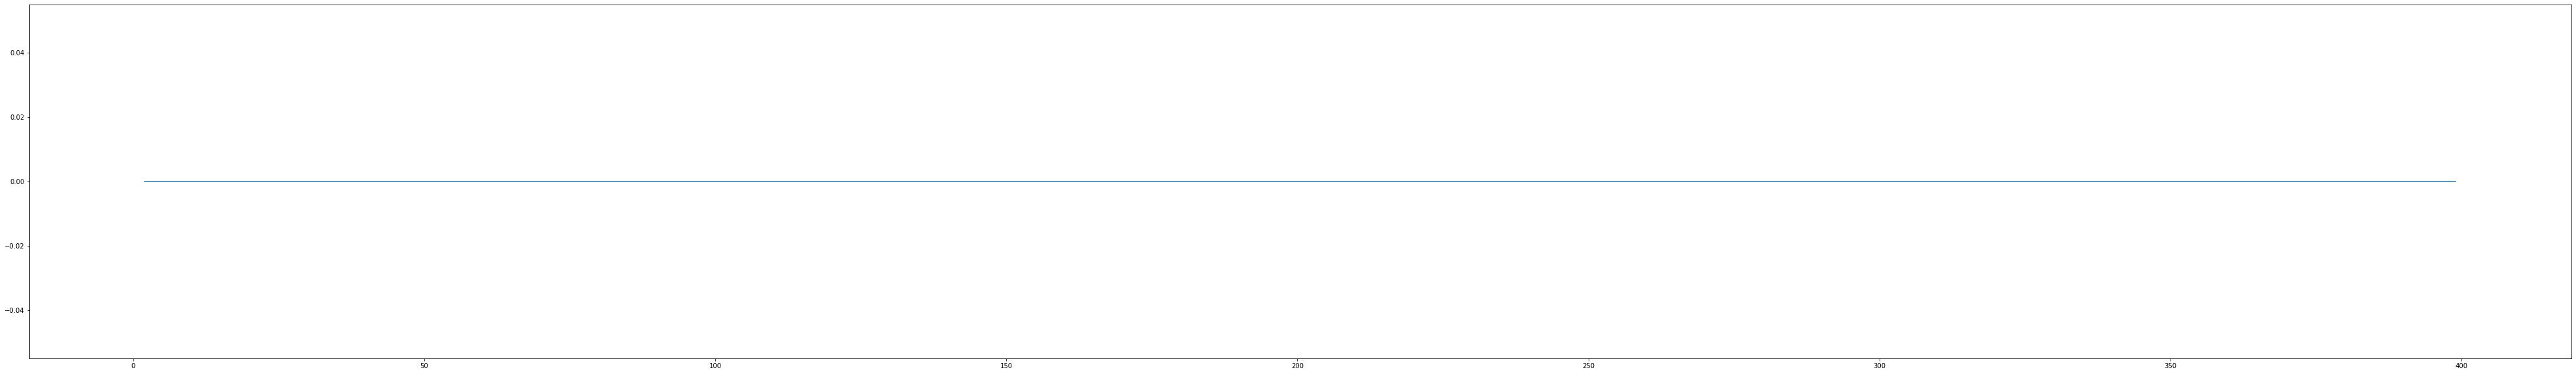

In [34]:
# Additive Decomposition
result_add = seasonal_decompose(df.TG, model='additive', extrapolate_trend=7, period = 365,two_sided=True)

plt.rcParams.update({'figure.figsize': (70,10)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show() 
tp.TG = data_temperature.TG

tp.TG = tp.TG - result_add.trend - result_add.seasonal

print(np.mean(tp.TG))
#tp.TG.hist(bins = 100, density = True)
plt.plot(tp.TG[2:401]-tp.TG[1:400])


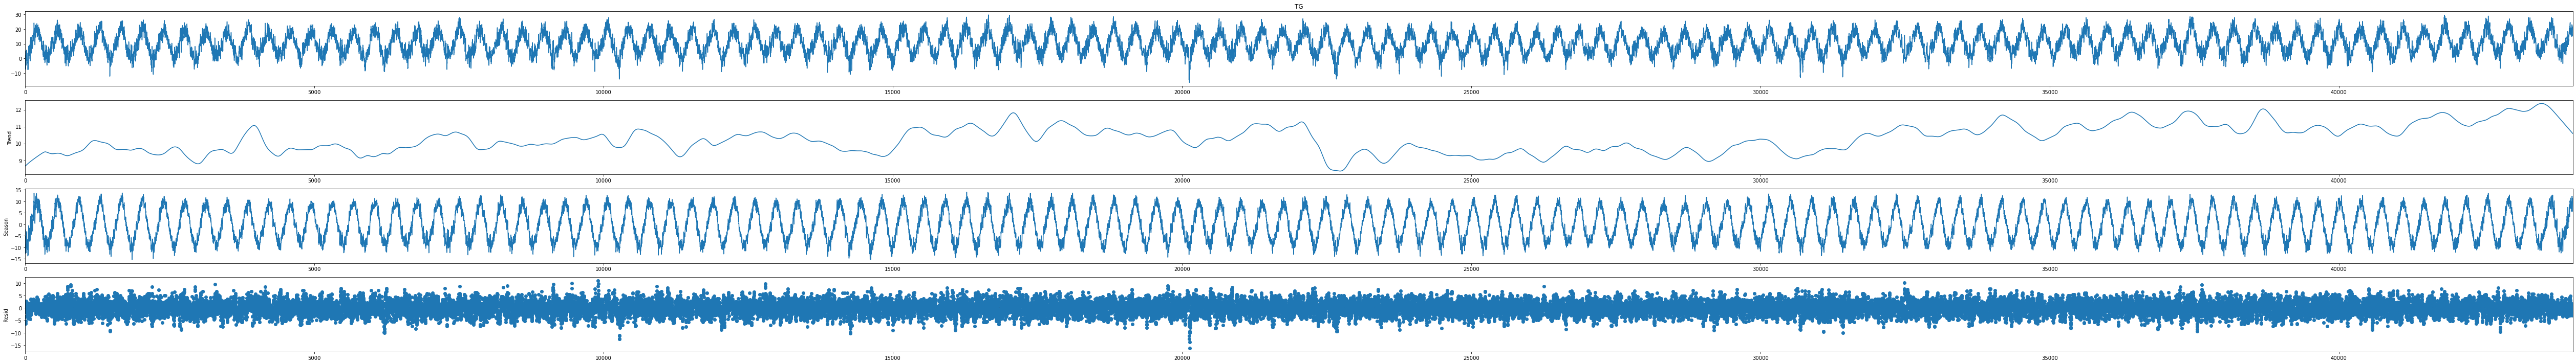

0.0004284051485839722


<AxesSubplot:>

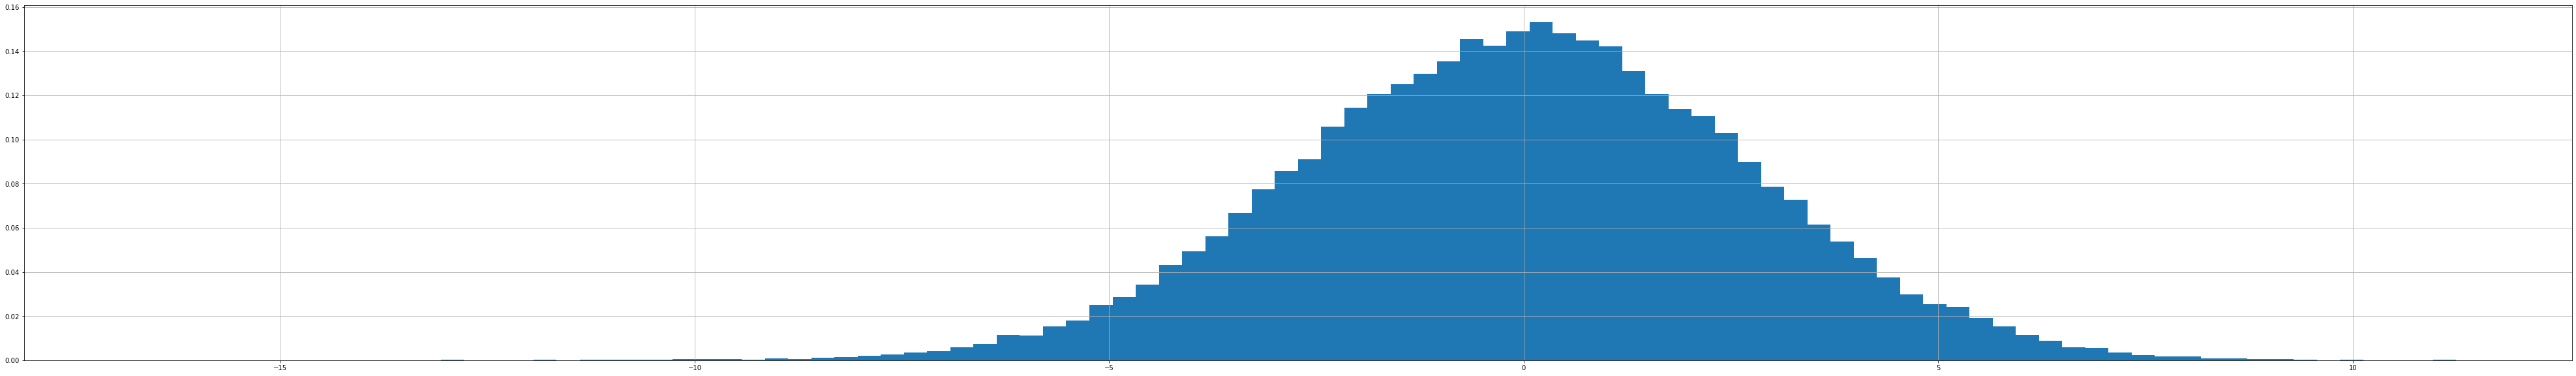

In [29]:
res = STL(df.TG, period = 365).fit()
res.plot()
plt.show()


tp.TG = data_temperature.TG

tp.TG = tp.TG - res.seasonal - np.mean(tp.TG)

print(np.mean(tp.TG))
tp.TG.hist(bins = 100, density = True)

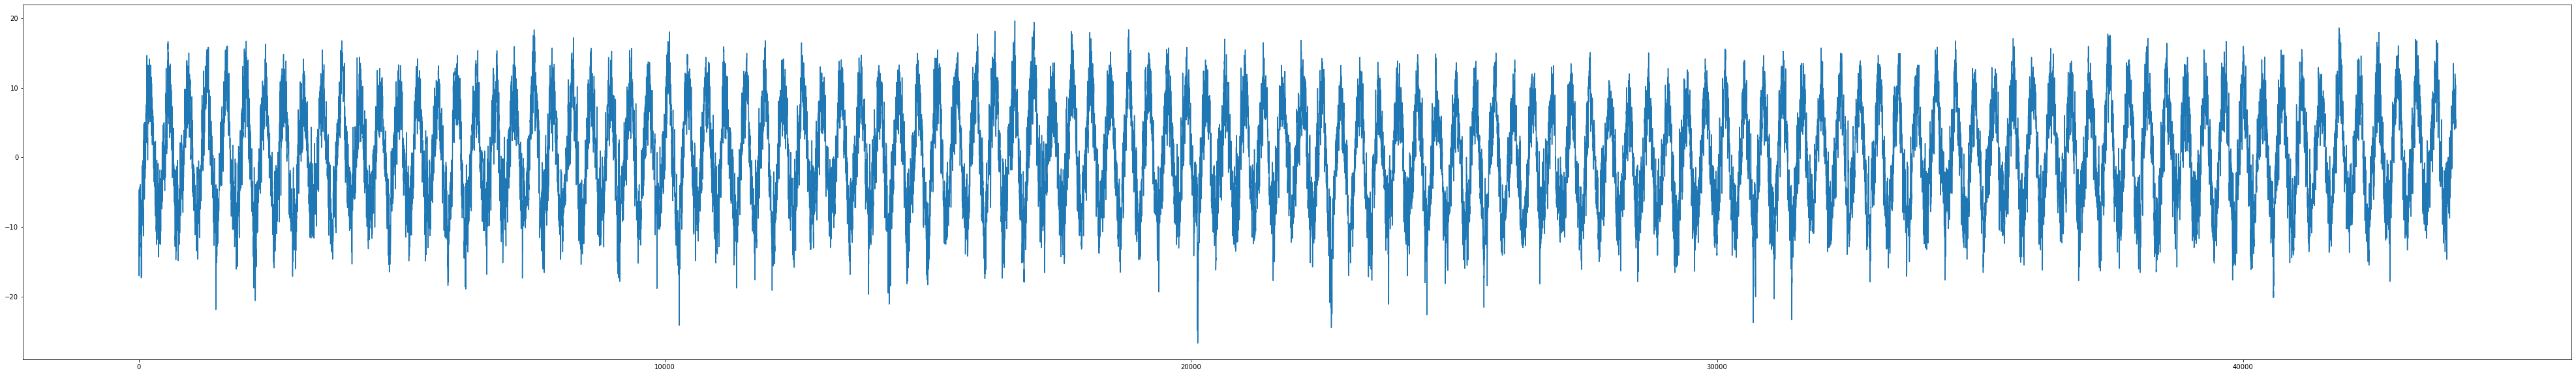

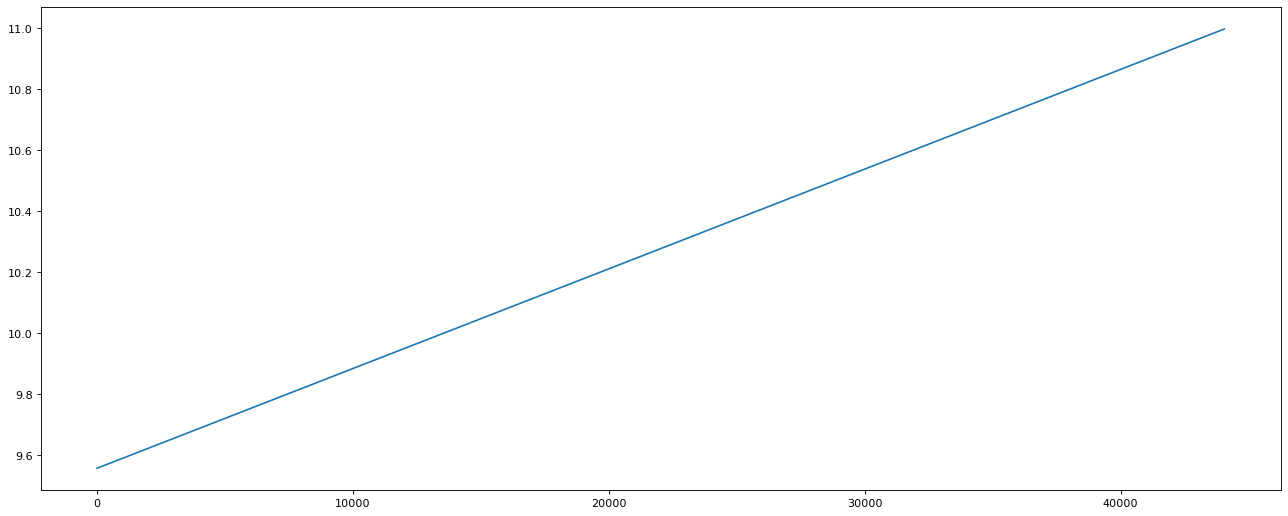

In [31]:
# Using scipy: Subtract the line of best fit
detrended1 = sc.signal.detrend(df.TG)
trend1 = df.TG - detrended1

plt.plot(detrended1)
plt.show()
plt.figure(figsize=(20,8), dpi= 80)
plt.plot(trend1)
plt.show()

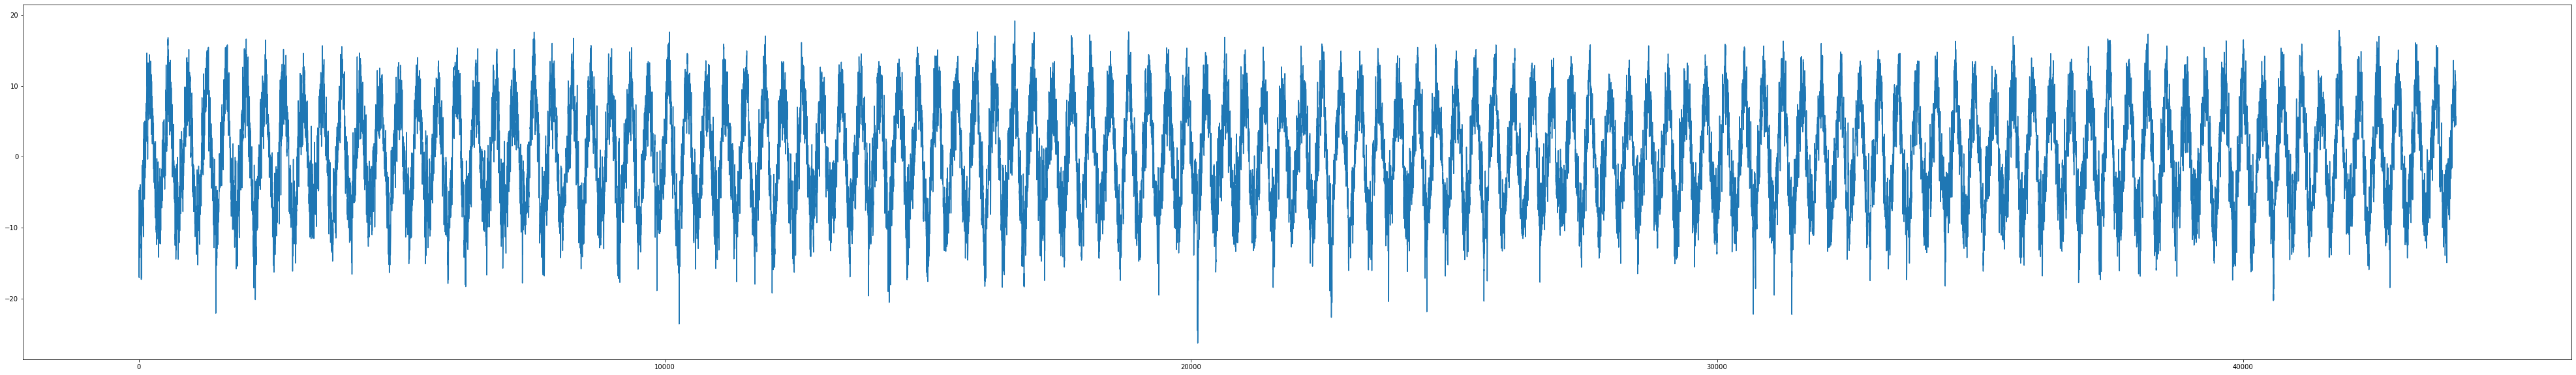

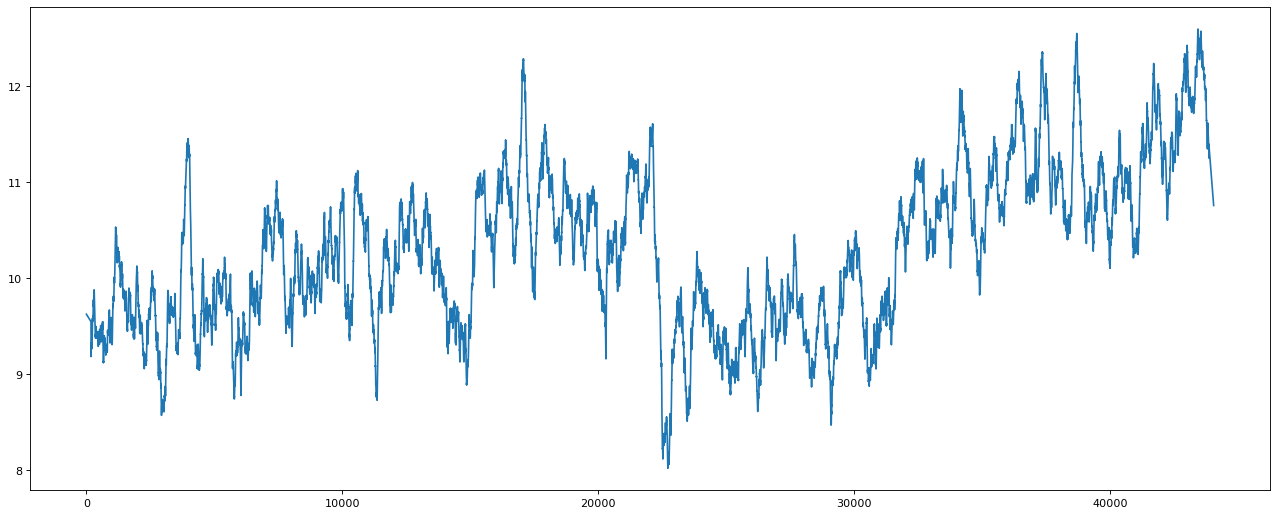

In [37]:
# Using statmodels: Subtracting the Trend Component.

result_add = seasonal_decompose(df.TG, model='additive', extrapolate_trend='freq',period = 365)
detrended = df.TG - result_add.trend
plt.plot(detrended)
plt.figure(figsize=(20,8), dpi= 80)
plt.plot(df.TG-detrended)


[ 1.          0.95946865 -0.04057756  0.16709001  0.08676412  0.07871117]


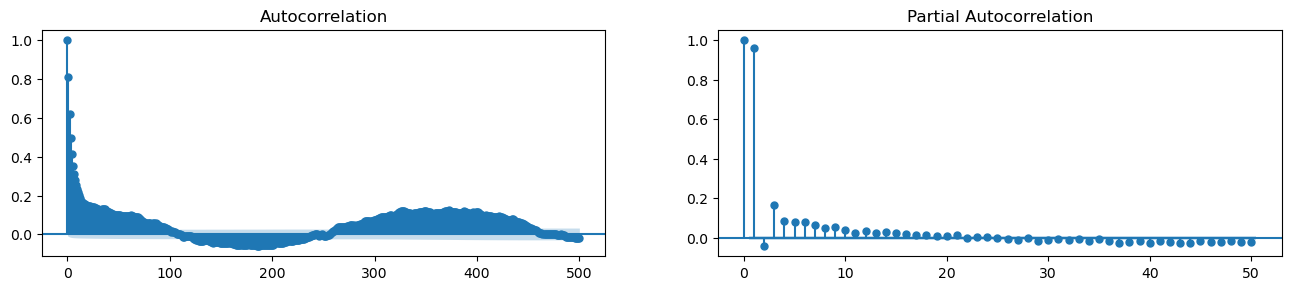

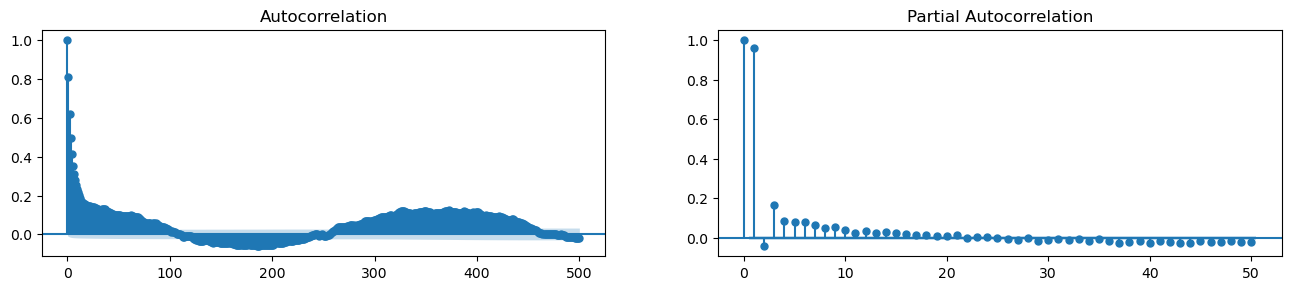

In [38]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
pacf_50 = pacf(df.TG, nlags=50)
print(pacf_50[:6])
# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df.TG, lags=50, ax=axes[0])
plot_pacf(df.TG, lags=50, ax=axes[1])

In [45]:
arma_mod = ARIMA(df.TG, order=(5, 0, 0)).fit()
print(arma_mod.params)

const     0.006724
ar.L1     0.960314
ar.L2    -0.198615
ar.L3     0.085386
ar.L4     0.005877
ar.L5     0.053741
sigma2    3.988086
dtype: float64


# Estimation de la tendance et de la saisonnalité
Nous allons ici, chercher la façon la optimale de modéliser la saisonalité et la tendance de notre time series pour ensuite pouvoir vérifier si elle est stationnaire et enfin faire du forecasting sur une time series stationaire. 

## Modélisation de la composante saisonière par moyenne par jours de l'année
On estimite la composante saisonière en prenant la moyenne de température de chaque jours de l'année à travers toutes les années. 

In [217]:
average_seasonal_component = [df[df.Day_of_year == j+1].TG.mean() for j in range(0,366)]
day = np.array(df.Day_of_year)
df['Season_TG'] = [average_seasonal_component[d-1] for d in day]
df["Seasonless_TG"] = df.TG-df.Season_TG

(0.0, 44044.0)

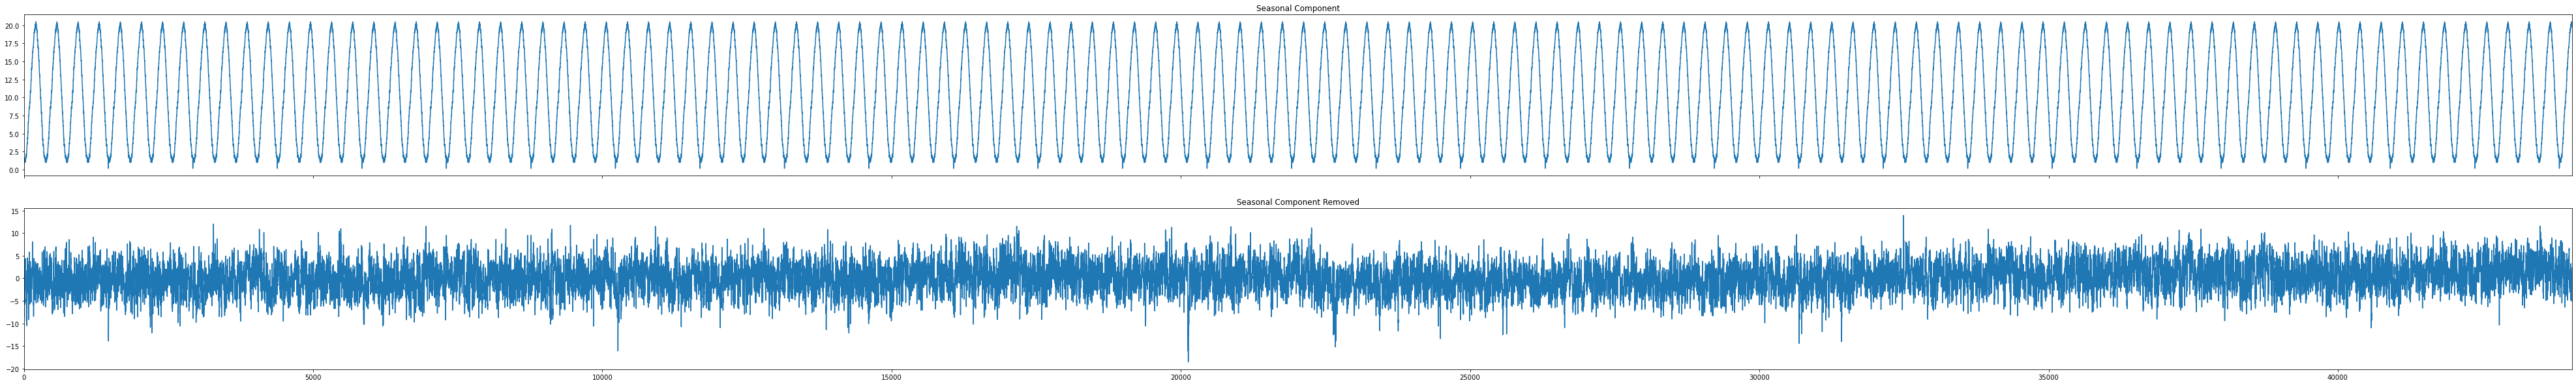

In [218]:
fig, axs = plt.subplots(2,sharex = True)
axs[0].plot(df.Season_TG)
axs[0].set_title('Seasonal Component')
axs[1].plot(df.TG-df.Season_TG)
axs[1].set_title('Seasonal Component Removed')
plt.xlim(0,np.shape(df.Season_TG)[0])

## Modélisation de la tendance, après avoir enlevé la saisonnalité, par interpolation linéaire

In [199]:
# Inutile pour le moment
def convolution_avg(X,i,l = 3):
    avg = X[max(i-l,0):min(i+l+1,np.shape(X)[0])].mean()
    return avg

#Trop de variation pour la tendance
#L = 31
#average_trend = [convolution_avg(df.TG-df.Season_TG,i,l=L) for i in range(np.shape(df.TG)[0])]

In [248]:
df["Detrended_Seasonless_TG"] = sc.signal.detrend(df.Seasonless_TG)

# trend_TG = a*t + b
i = 2
a = (df.Seasonless_TG[i+1]-df.Detrended_Seasonless_TG[i+1]) - (df.Seasonless_TG[i]-df.Detrended_Seasonless_TG[i])
b = df.Seasonless_TG[0]-df.Detrended_Seasonless_TG[0]
f_trend = lambda u: a*u + b

#plt.figure(figsize=(70,8))
#plt.plot(df.Seasonless_TG-detrended, linewidth = 1)
#plt.plot(df.Seasonless_TG, linewidth = 1)

# Tests sur les Time Series pour tester l'hypothèse de normalité
Dans cette partie, nous allons tester une hypothèse de normalité $X\sim \mathcal{N}(\mu,\,\sigma^{2})$ sur la time serie des températures moyennes désaisonnalisé $X$.
Plus précisément, nous allons d'abord tester les hypothèses :
- $H_0: \mu > 0$
- $H_0: \mu < 0$

Cela nous permettra de savoir si 